In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import uniform_filter, gaussian_filter
import os


In [3]:
# Path to your input file (update with your own file path)
inpath = "/content/ch2_tmc_ncn_20220101T0110303578_b_brw_d1819.jpeg"

# Load as grayscale
img_pil = Image.open(inpath).convert("L")
orig = np.array(img_pil).astype(np.float32)
print("Original shape:", orig.shape)


Original shape: (400, 400)


In [4]:
scale_factor = 5  # 5m → 1m
w0, h0 = img_pil.size
upsampled_pil = img_pil.resize((w0 * scale_factor, h0 * scale_factor), Image.Resampling.BICUBIC)
upsampled = np.array(upsampled_pil).astype(np.float32)
print("Upsampled shape:", upsampled.shape)

# Normalize to 0–1 range
elev = upsampled / 255.0


Upsampled shape: (2000, 2000)


In [5]:
# Pixel size after upsampling = 1m
dz_dy, dz_dx = np.gradient(elev, 1.0, 1.0)
slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
slope_deg = np.degrees(slope_rad)


In [6]:
window_size = 11  # ~11m window
mean = uniform_filter(elev, size=window_size, mode='reflect')
mean_sq = uniform_filter(elev**2, size=window_size, mode='reflect')
var = mean_sq - mean**2
var[var < 0] = 0
roughness = np.sqrt(var)


In [7]:
# Laplacian approximation
d2x = np.gradient(dz_dx, 1.0, axis=1)
d2y = np.gradient(dz_dy, 1.0, axis=0)
laplacian = d2x + d2y

crater_score = -laplacian
crater_score[crater_score < 0] = 0
crater_score = gaussian_filter(crater_score, sigma=2.0)


In [8]:
def norm01(x):
    mn, mx = np.nanmin(x), np.nanmax(x)
    return (x - mn) / (mx - mn) if mx > mn else np.zeros_like(x)

nslope = norm01(slope_deg)
nrough = norm01(roughness)
ncrater = norm01(crater_score)


In [9]:
# Weights (adjustable)
w_slope, w_rough, w_crater = 0.5, 0.3, 0.2

hazard = w_slope * nslope + w_rough * nrough + w_crater * ncrater
hazard = norm01(hazard)


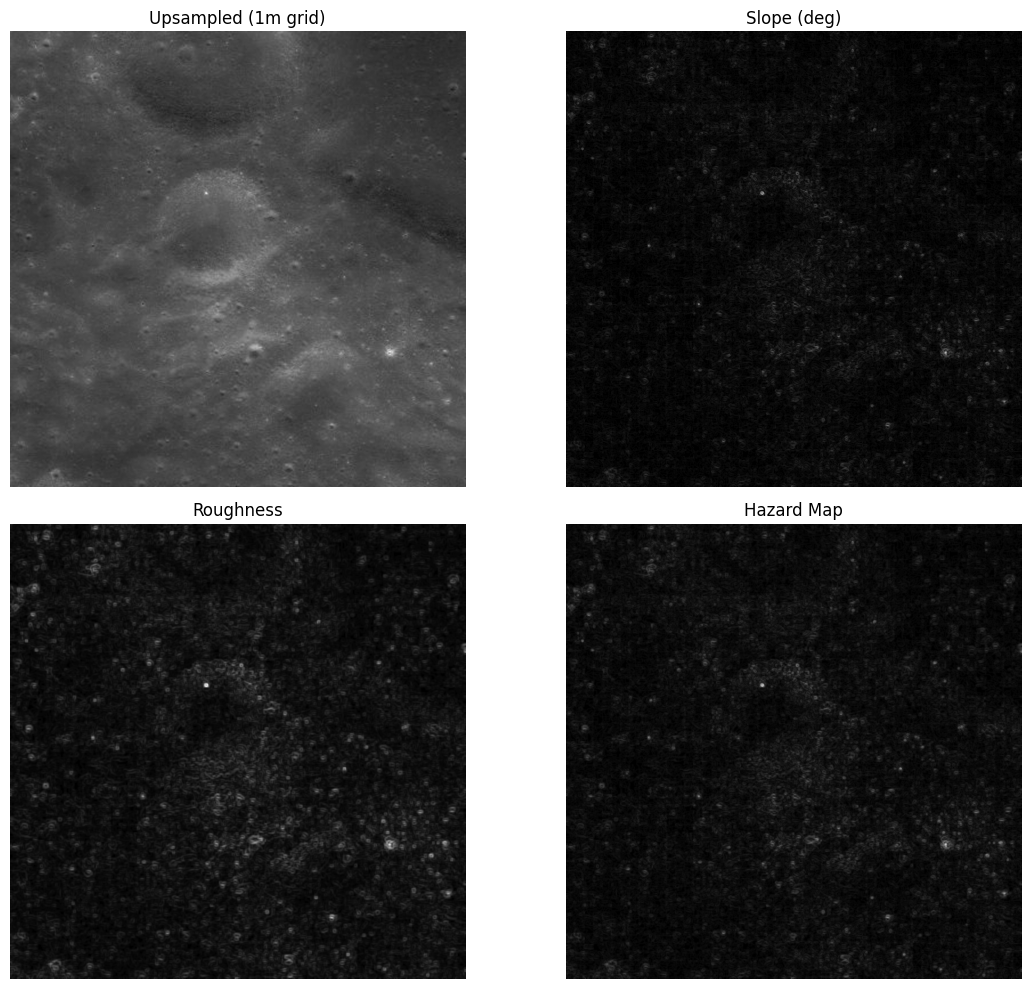

In [12]:
plt.figure(figsize=(12, 10))

plt.subplot(2,2,1)
plt.title("Upsampled (1m grid)")
plt.imshow(elev, cmap="gray")
plt.axis("off")

plt.subplot(2,2,2)
plt.title("Slope (deg)")
plt.imshow(nslope, cmap="gray")
plt.axis("off")

plt.subplot(2,2,3)
plt.title("Roughness")
plt.imshow(nrough, cmap="gray")
plt.axis("off")

plt.subplot(2,2,4)
plt.title("Hazard Map")
plt.imshow(hazard, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


In [13]:
out_dir = "outputs"
os.makedirs(out_dir, exist_ok=True)

Image.fromarray((nslope*255).astype(np.uint8)).save(os.path.join(out_dir, "slope.png"))
Image.fromarray((nrough*255).astype(np.uint8)).save(os.path.join(out_dir, "roughness.png"))
Image.fromarray((ncrater*255).astype(np.uint8)).save(os.path.join(out_dir, "crater.png"))
Image.fromarray((hazard*255).astype(np.uint8)).save(os.path.join(out_dir, "hazard_map.png"))

np.save(os.path.join(out_dir, "hazard_array.npy"), hazard)

print("✅ All outputs saved in:", out_dir)


✅ All outputs saved in: outputs
